In [16]:
# load libraries and scripts
import JSON
using Plots
using HDF5
using Trapz
include("../scripts/tools.jl")
include("../scripts/get_grid.jl")
include("../scripts/get_params.jl")
include("../scripts/disturbances.jl")
include("../scripts/stable.jl")
include("../scripts/dynamics.jl")

perform_dyn_sim (generic function with 1 method)

In [17]:
#load borders
border = import_border("../data/borders/border.json")

# create the lattice grid
dx = 20
Nx, Ny, xrange, yrange, isinside, isborder, n = get_grid(border, Float64(dx))

# define x and y coordinate for plotting
x = repeat(reshape(xrange,1,Nx), Ny, 1)
y = repeat(reshape(yrange,Ny,1), 1, Nx);

In [18]:
# compute or load grid parameters
recompute_param = true
if(recompute_param || isfile("../numerics/grid_params_" * string(dx) * ".h5"))
    bx, by, p, m, d = get_params_diff(isinside, n, Float64(dx), yrange, xrange, "../data/disc/pantagruel.h5",
        "../numerics/grid_params_" * string(dx) * ".h5", Niter = 10000, dmax = 10.0, patch=0.003, bmin=0.01)
    #bx, by, p, m, d = get_params(isinside, isborder, Float64(dx), yrange, xrange, "../data/pantagruel.h5",
    #    "../numerics/grid_params_" * string(dx) * ".h5")
else
    bx, by, p, m, d = get_params(isinside, "../numerics/grid_params_" * string(dx) * ".h5")
end

Done with inertia.
Done with damping.
Done with with generation.
Done with load.
118.287928 seconds (6.17 G allocations: 100.807 GiB, 17.86% gc time, 0.00% compilation time)


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [19]:
# compute, iteratively, the stable solution
th0, ths = compute_stable_sol(isinside, n, bx, by, p, Niter = 20000, interval = 1000);

[1000.0 0.0003348815756090695]
[2000.0 0.00020812404799142037]
[3000.0 0.0001460022834901542]
[4000.0 0.00012654419934277072]
[5000.0 0.00010659595756945528]
[6000.0 7.547701246257699e-5]
[7000.0 5.665383231900911e-5]
[8000.0 5.57335062563169e-5]
[9000.0 3.803679110947478e-5]
[10000.0 3.673234156909011e-5]
[11000.0 3.156170523088697e-5]
[12000.0 2.3875483202706604e-5]
[13000.0 2.550852275384763e-5]
[14000.0 1.8875482180158443e-5]
[15000.0 1.7200866579081264e-5]
[16000.0 1.5816792090506127e-5]
[17000.0 1.4771300092197848e-5]
[18000.0 1.4306121342899658e-5]
[19000.0 1.585417071781059e-5]
[20000.0 1.4766590320069994e-5]
 28.768647 seconds (1.24 G allocations: 18.653 GiB, 21.32% gc time, 0.35% compilation time)


0.0


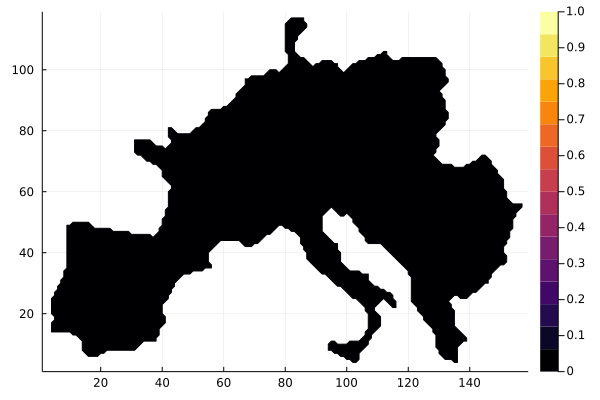

In [20]:
# define a disturbance
# dP = -9.0
dP = 0.0
sigma = 50.0
location = [-1500., -900.]
dp = local_disturbance(isinside, xrange, yrange, location, dP, sigma)
println(trapz((yrange, xrange), dp))
ctr_plot(isinside, dp)

In [21]:
# perform a dynamical simulation
ts, thetas, omegas = perform_dyn_sim(isinside, n, bx, by, p+dp, m, d, th0, interval = 1000, Ndt = Int64(2E5), dt = 0.0001);

NIter: 1000
NIter: 2000
NIter: 3000
NIter: 4000
NIter: 5000
NIter: 6000
NIter: 7000
NIter: 8000
NIter: 9000
NIter: 10000
NIter: 11000
NIter: 12000
NIter: 13000
NIter: 14000
NIter: 15000
NIter: 16000
NIter: 17000
NIter: 18000
NIter: 19000
NIter: 20000
NIter: 21000
NIter: 22000
NIter: 23000
NIter: 24000
NIter: 25000
NIter: 26000
NIter: 27000
NIter: 28000
NIter: 29000
NIter: 30000
NIter: 31000
NIter: 32000
NIter: 33000
NIter: 34000
NIter: 35000
NIter: 36000
NIter: 37000
NIter: 38000
NIter: 39000
NIter: 40000
NIter: 41000
NIter: 42000
NIter: 43000
NIter: 44000
NIter: 45000
NIter: 46000
NIter: 47000
NIter: 48000
NIter: 49000
NIter: 50000
NIter: 51000
NIter: 52000
NIter: 53000
NIter: 54000
NIter: 55000
NIter: 56000
NIter: 57000
NIter: 58000
NIter: 59000
NIter: 60000
NIter: 61000
NIter: 62000
NIter: 63000
NIter: 64000
NIter: 65000
NIter: 66000
NIter: 67000
NIter: 68000
NIter: 69000
NIter: 70000
NIter: 71000
NIter: 72000
NIter: 73000
NIter: 74000
NIter: 75000
NIter: 76000
NIter: 77000
NIter: 7

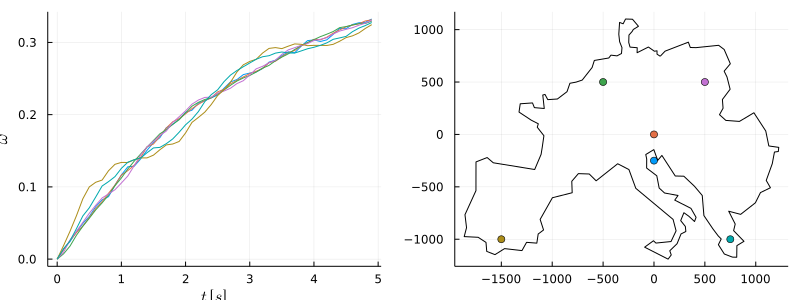

In [23]:
# plotting the frequency at different locations
coord = [0 -250; 0.0 0.0; -500 500; 500. 500.; -1500.0 -1000.0; 750.0 -1000]
time_plot(ts, omegas, coord, tstart = 0.0, tend = 5.0, borders = [border])

┌ Info: Saved animation to 
│   fn = /home/laurent/ContGridMod/notebooks/tmp.gif
└ @ Plots /home/laurent/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/home/laurent/ContGridMod/notebooks/tmp.gif")
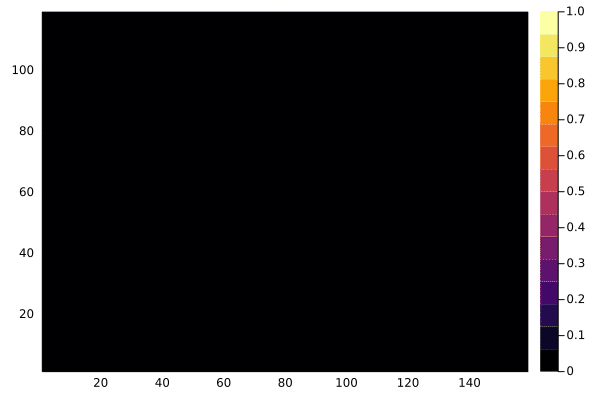

In [11]:
# evolution of the frequency
ctr_movie(ts, omegas, tstart = 0.0, tend = 50.0)

In [27]:
sum(p[isinside .| isborder])

LoadError: MethodError: no method matching typed_hcat(::Matrix{Float64}, ::BitMatrix, ::BitMatrix)
[0mClosest candidates are:
[0m  typed_hcat([91m::Type{T}[39m, ::AbstractVecOrMat{T} where T...) where T at abstractarray.jl:1505
[0m  typed_hcat([91m::Type[39m, ::AbstractArray, ::AbstractArray) at abstractarray.jl:1797
[0m  typed_hcat([91m::Type[39m, ::AbstractArray...) at abstractarray.jl:1798
[0m  ...